*First compiled on May 25, 2017.*

# Graph abstraction for hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 1                # increase for more output
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()
results_file = './write/nestorowa16_171011.h5'

Running Scanpy version 0.2.8+35.g563ceec on 2017-10-25 11:23.


## Preprocessing

In [54]:
adata = sc.read('./data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.txt', cache=True)

reading ./write/data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.h5


In [55]:
acronyms = {
    'ESLAM': 'Stem',
    'Erythroid': 'Ery',
    'Megakaryocytes': 'Mk',
    'Basophils': 'Baso',
    'Neutrophils': 'Neu',
    'Monocytes': 'Mo',
    'Bcell': 'B'
}
exp_groups = pd.read_csv('./data/nestorowa16/data_171011/nestorowa_corrected_population_annotation.txt', delimiter=' ')

In [56]:
exp_groups = [acronyms[exp_groups.loc[cell_id, 'celltype']]
              if cell_id in exp_groups.index else 'no_gate' for cell_id in adata.smp_names]
adata.smp['exp_groups'] = exp_groups

In [57]:
sc.pp.recipe_weinreb16(adata)
adata.add['iroot'] = np.flatnonzero(adata.smp['exp_groups'] == 'Stem')[0]

In [58]:
sc.tl.diffmap(adata, n_neighbors=4)
sc.tl.draw_graph(adata, n_neighbors=4)
sc.tl.tsne(adata)

In [59]:
sc.write(results_file, adata)

writing ./write/nestorowa16_171011.h5


saving figure to file ./figures/draw_graph_fr.png


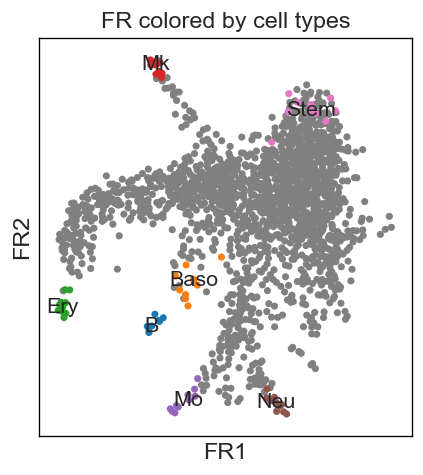

saving figure to file ./figures/tsne.png


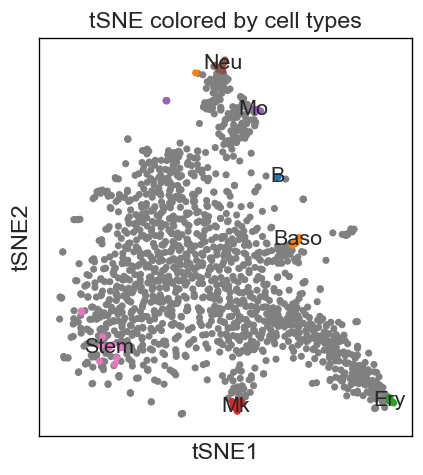

In [4]:
ax = sc.pl.draw_graph(adata, color='exp_groups', title='FR colored by cell types', legend_loc='on data', save=True)
ax = sc.pl.tsne(adata, color='exp_groups', title='tSNE colored by cell types', legend_loc='on data', save=True)

Export for comparison with Monocle 2.

In [66]:
adata_raw = sc.read('./data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
adata_raw.add['exp_groups_colors'] = adata.add['exp_groups_colors']
adata_raw.add['exp_groups_order'] = adata.add['exp_groups_order']
sc.write(results_file[:-3] + '_raw.csv', adata_raw)

reading ./write/data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.h5
writing csv files to ./write/nestorowa16_171011_raw/


## Estimate connectivity of cell groups using graph abstraction

We use the same number of neighbors as for visualizing the data above and as in [*paul15*](../paul15).

In [80]:
adata = sc.read(results_file)
sc.tl.aga(adata, n_neighbors=4, resolution=1.4)
sc.write(results_file, adata)

reading ./write/nestorowa16_171011.h5
writing ./write/nestorowa16_171011.h5


reading ./write/nestorowa16_171011.h5


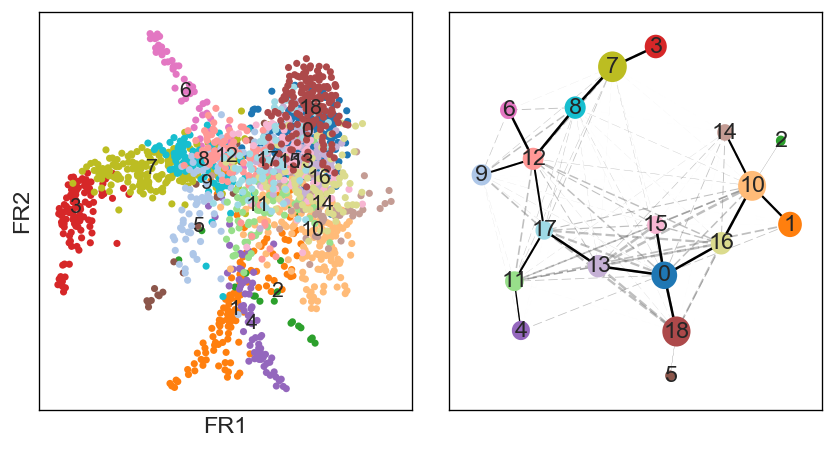

In [81]:
adata = sc.read(results_file)
axs = sc.pl.aga(adata, title='', title_graph='', basis='draw_graph_fr',
                color='aga_groups', groups_graph='aga_groups', layout='fr')

reading ./write/nestorowa16_171011.h5
saving figure to file ./figures/aga_graph.png


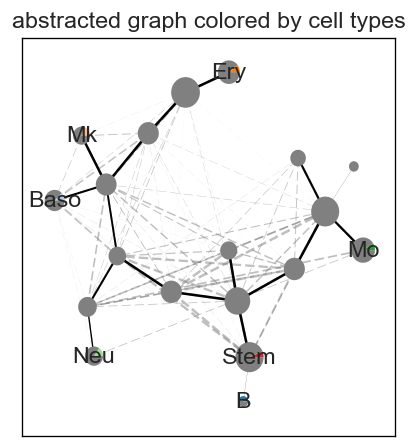

In [2]:
adata = sc.read(results_file)
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)
axs = sc.pl.aga_graph(adata,
                      title='abstracted graph colored by cell types',
                      color=asso_colors, groups=asso_names, layout='fr', save=True)

reading ./write/nestorowa16_171011.h5
exporting to ./write/aga_graph.gexf


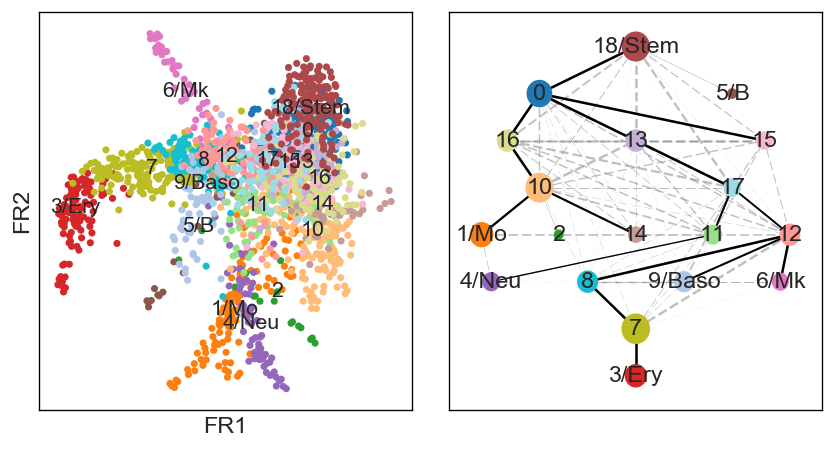

In [2]:
adata = sc.read(results_file)
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction', max_n_names=1)
adata.add['aga_groups_order'] = ['{}'.format(name)
                                  + ('/{}'.format(asso_names[iname]) if len(asso_names[iname])>0 else '') # replace integers
                                 for iname, name in enumerate(adata.add['aga_groups_order'])]
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=18, color='aga_groups', groups_graph='aga_groups',
                layout='eq_tree', export_to_gexf=True)

Use Gephi to manually adjust the positions of the nodes. Read in the positions from the exported gdf file.

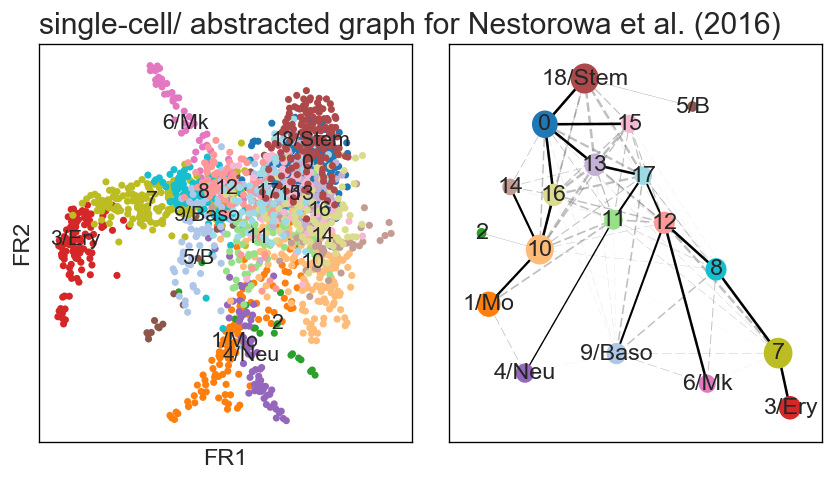

In [7]:
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                color='aga_groups', groups_graph='aga_groups', show=False,
                pos='./write/aga_graph_gephi.gdf')
axs[0].set_title('single-cell/ abstracted graph for Nestorowa et al. (2016)', loc='left', fontsize=18)
pl.savefig('./figures/aga_gephi.png', dpi=500)
pl.show()

reading ./write/nestorowa16_171011.h5
saving figure to file ./figures/aga_graph.png


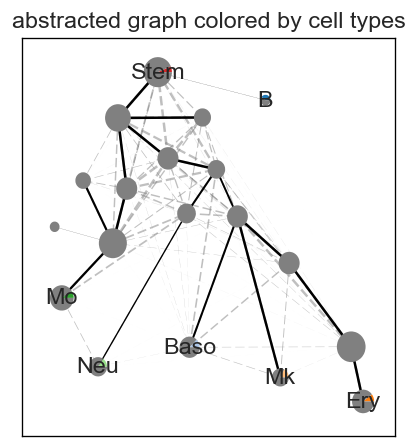

In [3]:
adata = sc.read(results_file)
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)
axs = sc.pl.aga_graph(adata, pos='./write/aga_graph_gephi.gdf',
                      title='abstracted graph colored by cell types',
                      color=asso_colors, groups=asso_names, layout='fr', save=True)

In [6]:
sc.write('./write/nestorowa16_171011.csv', adata)

writing csv files to ./write/nestorowa16_171011/


## Reconstruct gene changes for some marker genes.

Some marker genes.

| cell type | marker |
| --- | --- |
| Erythroids | Gata1, Gypa, Hba-a2, Hba-a1 |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Prss34, Ms4a2, Fcer1a, Siglecf |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Neutrophils | Elane, Ctsg, Mpo, Gfi1 | 
|B cells | Cd19, Vpreb2, Cd79a |

In [4]:
adata = sc.read(results_file)
adata_all_genes = adata_raw = sc.read('./data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
adata_all_genes.smp['aga_groups'] = adata.smp['aga_groups']
adata_all_genes.add['aga_groups_order'] = adata.add['aga_groups_order']
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading ./write/nestorowa16_171011.h5
reading ./write/data/nestorowa16/data_171011/nestorowa_corrected_log2_transformed_counts.h5


In [5]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

reading ./write/nestorowa16_171011.h5


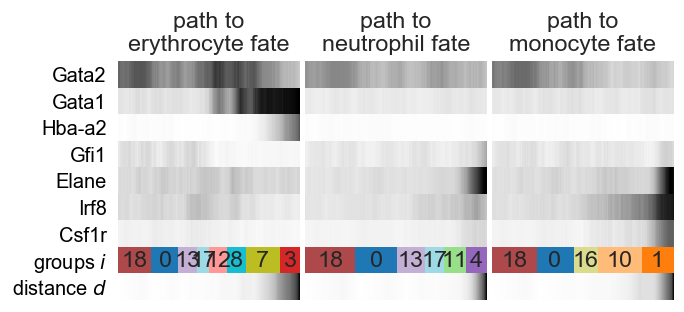

In [7]:
adata = sc.read(results_file)
paths = [('erythrocytes', [18, 0, 13, 17, 12, 8, 7, 3]),
         ('neutrophils', [18, 0, 13, 17, 11, 4]),
         ('monocytes', [18, 0, 16, 10, 1])]
rcParams['figure.figsize'] = (6, 2.5)
rcParams['figure.subplot.top'] = 0.82
rcParams['figure.subplot.bottom'] = 0.2
rcParams['figure.subplot.right'] = 0.92
_, axs = pl.subplots(ncols=3, gridspec_kw={'wspace': 0.03})
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.aga_path(adata_all_genes, ax=axs[ipath],
                             left_margin=0.15,
                             nodes=path,
                             ytick_fontsize=12,
                             keys=gene_names,
                             n_avg=50,
                             show_yticks=True if ipath==0 else False,
                             show_colorbar=False,
                             title='path to\n{} fate'.format(descr[:-1]),
                             return_data=True, show=False)
    data.to_csv('./write/aga_path_{}.csv'.format(descr))
pl.savefig('./figures/aga_path.pdf', dpi=300)
pl.show()
sc.pl.reset_rcParams()